In [1]:
import os
data_path = "D:\output_files"
print("Number of Patients:", len(os.listdir(data_path)))

Number of Patients: 1253


In [47]:
def load_niigz(file_path):
    niigz_image = nib.load(file_path)
    return niigz_image.get_fdata()

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [49]:
def MRI_Slices_visual(patient_folder):
   
   modalities = {
       "T1": os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t1.nii.gz"),
       "T1ce": os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t1ce.nii.gz"),
       "T2": os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_t2.nii.gz"),
       "FLAIR": os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_flair.nii.gz"),
       "Segmentation Mask":  os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_seg.nii.gz")
   }


   
   imgs = {mod: load_niigz(path) for mod, path in modalities.items()}

   
   slice_idx = imgs['T1'].shape[2] // 2


   
   fig, axes = plt.subplots(1, 5, figsize = (20,5))
   for i, (modality, img) in enumerate(imgs.items()):
      axes[i].imshow(img[:, :, slice_idx], cmap= 'gray' if modality != 'Segmentation Mask' else 'jet')
      axes[i].set_title(modality)
      axes[i].axis('off')

   plt.show()

In [9]:

patient_sample = "D:\output_files\BraTS2021_00000"
modal_name = 't2'
sample_arr = load_niigz(os.path.join(patient_sample, f"BraTS2021_00000_{modal_name}.nii.gz"))

print(sample_arr.shape)

NameError: name 'load_niigz' is not defined

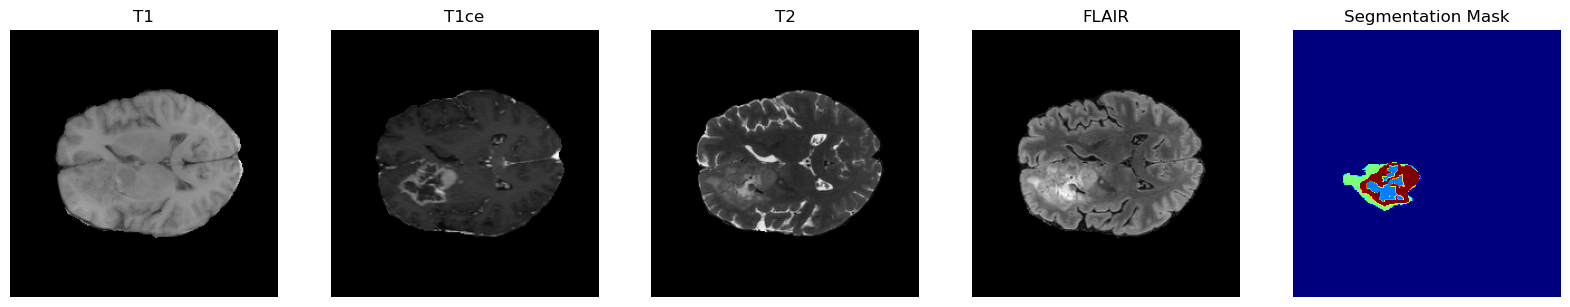

In [51]:

MRI_Slices_visual(patient_folder = patient_sample)

In [52]:



def check_missing_modalities(data_path):
    required_modalities = ['t1.nii.gz', 't1ce.nii.gz', 't2.nii.gz', 'flair.nii.gz', 'seg.nii.gz']

    missing_files = []

    for patient in sorted(os.listdir(data_path)):

        path_xi = os.path.join(data_path, patient)

        if os.path.isdir(path_xi):
           for modality in required_modalities:
               if not os.path.exists(os.path.join(path_xi, f"{patient}_{modality}")):
                  missing_files.append(f"{path_xi}/{modality}")


    if missing_files:
          print('Missing files found !!')
          for f in missing_files:
            print(f)
    else:
          print('No Missing files found !!')



def check_full_null_pixel_values(data_path):

    empty_images = []

    for patient in sorted(os.listdir(data_path)):

        path_xi = os.path.join(data_path, patient)

        if os.path.isdir(path_xi):
           for file in os.listdir(path_xi):
               if file.endswith('.nii.gz'):
                  img_path = os.path.join(path_xi, file)
                  img_data = nib.load(img_path).get_fdata()

                  if np.all(img_data == 0):
                     empty_images.append(img_path)


    if empty_images:
       print('Empty Scans Found:')
       for f in empty_images:
            print(f)
    else:
       print('No empty scans detected')




def check_NaN_values(data_path):
    nan_files = []

    for patient in sorted(os.listdir(data_path)):

        path_xi = os.path.join(data_path, patient)

        if os.path.isdir(path_xi):
           for file in os.listdir(path_xi):
               if file.endswith('.nii.gz'):
                  img_path = os.path.join(path_xi, file)
                  img_data = nib.load(img_path).get_fdata()

                  if np.isnan(img_data).any():
                      nan_files.append(img_path)


    if nan_files:
      print('Nan files exists')
      for k in nan_files:
        print(k)

    else:
      print('No Nan values detected')

In [54]:
def plot_intensity_histograms(patient_folder):

    modalities = ["t1", "t1ce", "t2", "flair"]
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    for i, modality in enumerate(modalities):
        file_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_{modality}.nii.gz")
        image = nib.load(file_path).get_fdata()

        image_values = image.flatten()
        image_values = image_values[image_values > np.percentile(image_values, 0.5)]
        image_values = image_values[image_values < np.percentile(image_values, 99.5)]

        axes[i].hist(image_values, bins=100, color='blue', alpha=0.7, density=True)
        axes[i].set_title(f"Histogram of {modality.upper()} Intensities")
        axes[i].set_xlabel("Intensity")
        axes[i].set_ylabel("Normalized Frequency")
        axes[i].set_yscale("log")

    plt.show()


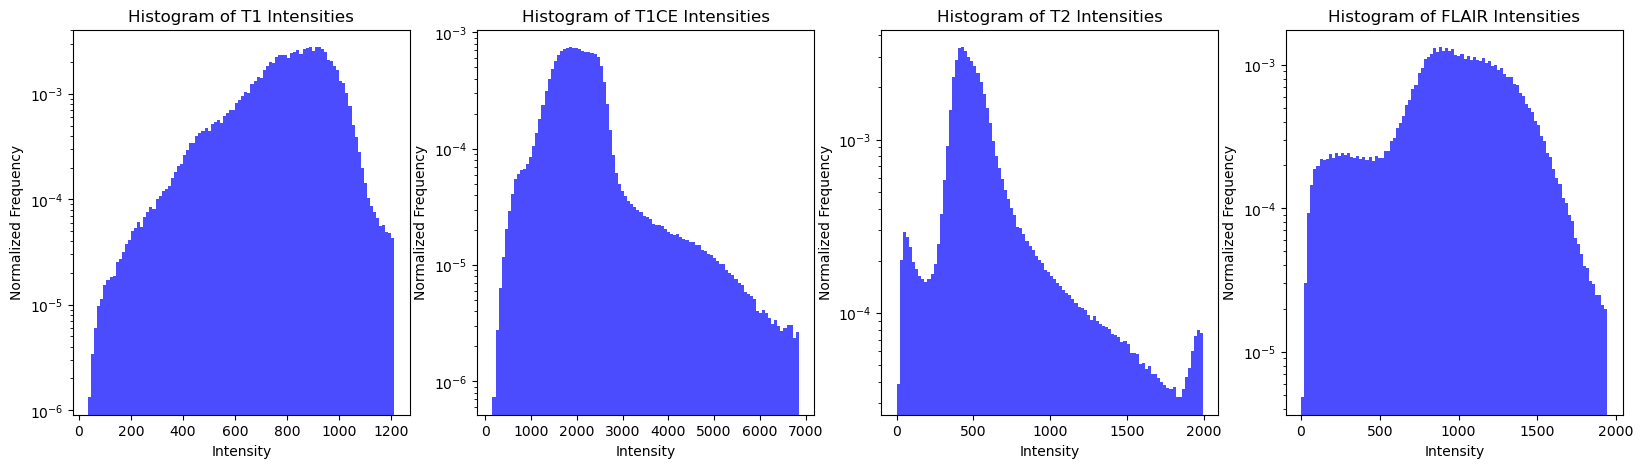

In [55]:
patient_example = "D:\output_files\BraTS2021_00000"
plot_intensity_histograms(patient_example)

In [56]:
def count_voxel_labels(patient_folder):

   path_xi = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_seg.nii.gz")
   segmentation = nib.load(path_xi).get_fdata()

   unique_labels, counts = np.unique(segmentation, return_counts = True)
   label_counts = dict(zip(unique_labels, counts))

   print(f"Voxel counts for {os.path.basename(patient_folder)}:")

   for label, count in label_counts.items():
       print(f"Label {int(label)}: {count} voxels")

In [57]:
count_voxel_labels(patient_example)

Voxel counts for BraTS2021_00000:
Label 0: 8870695 voxels
Label 1: 11738 voxels
Label 2: 12836 voxels
Label 4: 32731 voxels


In [58]:

def overlay_segmentation(patient_folder, slice_idx=None):

    flair_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_flair.nii.gz")
    seg_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_seg.nii.gz")

    flair_img = nib.load(flair_path).get_fdata()
    seg_img = nib.load(seg_path).get_fdata()

    if slice_idx is None:
        slice_idx = flair_img.shape[2] // 2

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(flair_img[:, :, slice_idx], cmap='gray')
    ax.imshow(seg_img[:, :, slice_idx], cmap='jet', alpha=0.4)
    ax.set_title(f"Overlay of Segmentation on FLAIR (Slice {slice_idx})")
    ax.axis("off")

    plt.show()

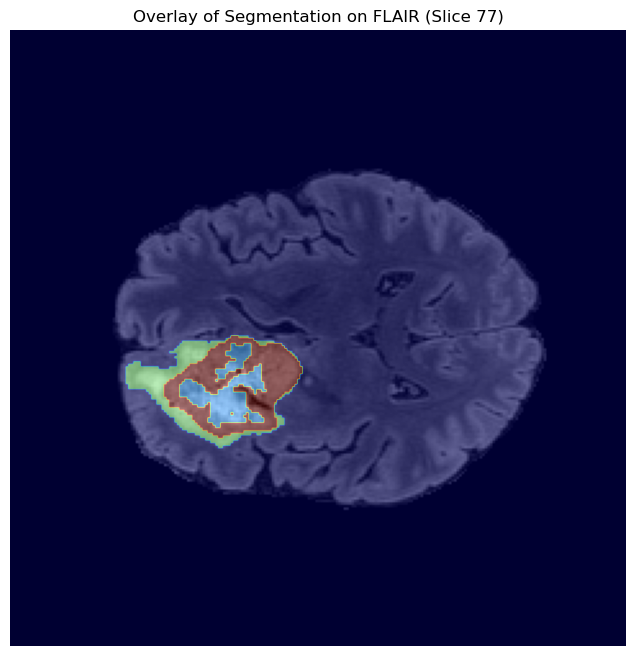

In [59]:
overlay_segmentation(patient_example)

In [60]:
def compute_tumor_volumes(patient_folder, voxel_volume=1):

    seg_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_seg.nii.gz")
    seg_img = nib.load(seg_path).get_fdata()

    unique_labels, counts = np.unique(seg_img, return_counts=True)

    tumor_volumes = {label: count * voxel_volume for label, count in zip(unique_labels, counts) if label != 0}

    print(f"Tumor Volumes (in voxel units) for {os.path.basename(patient_folder)}:")
    for label, volume in tumor_volumes.items():
        print(f"Label {int(label)}: {volume} mm³")

In [61]:
compute_tumor_volumes(patient_example)

Tumor Volumes (in voxel units) for BraTS2021_00000:
Label 1: 11738 mm³
Label 2: 12836 mm³
Label 4: 32731 mm³


In [62]:
import plotly.graph_objects as go


def visualize_3d_segmentation(patient_folder):
    """Render a 3D visualization of tumor segmentation using Plotly."""

    seg_path = os.path.join(patient_folder, f"{os.path.basename(patient_folder)}_seg.nii.gz")
    seg_img = nib.load(seg_path).get_fdata()

    x, y, z = np.where(seg_img > 0)

    fig = go.Figure(data=[go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=2,  
            color=z,  
            colorscale='Reds',  
            opacity=0.5
        )
    )])

    fig.update_layout(title="3D Tumor Segmentation", scene=dict(
        xaxis_title="X", yaxis_title="Y", zaxis_title="Z"
    ))

    fig.show()

patient_example = "D:\output_files\BraTS2021_00000"
visualize_3d_segmentation(patient_example)



In [63]:
## Phase 2: Using SMP based transfer learning to obtain initial results

In [4]:
import random
from glob import glob
import torchvision.transforms as trfs
import torch.nn.functional as F
import torch
import os


patient_directories = sorted(glob(os.path.join(data_path, "*")))

batch_size = int(0.05 * len(patient_directories))
subset_size = int(0.3 * len(patient_directories))
#selected_patients = random.sample(patient_directories, subset_size)
selected_patients = patient_directories[:subset_size]
print(selected_patients)


modalities = ["t1", "t1ce", "t2", "flair"]

imagenet_normalize = trfs.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)


['D:\\output_files\\BraTS2021_00000', 'D:\\output_files\\BraTS2021_00002', 'D:\\output_files\\BraTS2021_00003', 'D:\\output_files\\BraTS2021_00005', 'D:\\output_files\\BraTS2021_00006', 'D:\\output_files\\BraTS2021_00008', 'D:\\output_files\\BraTS2021_00009', 'D:\\output_files\\BraTS2021_00011', 'D:\\output_files\\BraTS2021_00012', 'D:\\output_files\\BraTS2021_00014', 'D:\\output_files\\BraTS2021_00016', 'D:\\output_files\\BraTS2021_00017', 'D:\\output_files\\BraTS2021_00018', 'D:\\output_files\\BraTS2021_00019', 'D:\\output_files\\BraTS2021_00020', 'D:\\output_files\\BraTS2021_00021', 'D:\\output_files\\BraTS2021_00022', 'D:\\output_files\\BraTS2021_00024', 'D:\\output_files\\BraTS2021_00025', 'D:\\output_files\\BraTS2021_00026', 'D:\\output_files\\BraTS2021_00028', 'D:\\output_files\\BraTS2021_00030', 'D:\\output_files\\BraTS2021_00031', 'D:\\output_files\\BraTS2021_00032', 'D:\\output_files\\BraTS2021_00033', 'D:\\output_files\\BraTS2021_00035', 'D:\\output_files\\BraTS2021_00036', 

In [5]:
import os
import nibabel as nib
import torch
import torch.nn.functional as F

def preprocessing_fxn_single_patient(patient_path, target_size=(256, 256, 155)):
    if not os.path.isdir(patient_path):
        return None

    modalities = ["t1", "t1ce", "t2", "flair"]  
    images = []

    patient_id = os.path.basename(patient_path)  

    for mod in modalities:
        file_path = os.path.join(patient_path, f"BraTS2021_{patient_id[-5:]}_{mod}.nii.gz")

        if not os.path.exists(file_path):
            print(f"Missing file: {file_path}")
            return None  

        image = nib.load(file_path).dataobj[:]  
        image = torch.tensor(image, dtype=torch.float32)

        image = image.unsqueeze(0).unsqueeze(0)  
        image = F.interpolate(image, size=target_size, mode="trilinear", align_corners=False)
        image = image.squeeze(0).squeeze(0)  
        min_val, max_val = image.min(), image.max()
        
        if max_val > min_val:
            image = (image - min_val) / (max_val - min_val)

        images.append(image)

    images = torch.stack(images)

    mean, std = images.mean(), images.std()
    images = (images - mean) / std

    mask_path = os.path.join(patient_path, f"BraTS2021_{patient_id[-5:]}_seg.nii.gz")
    if not os.path.exists(mask_path):
        print(f"Missing mask file: {mask_path}")
        return None  

    mask = nib.load(mask_path).dataobj[:]
    mask = torch.tensor(mask, dtype=torch.long)  

    mask = mask.unsqueeze(0).unsqueeze(0)
    mask = F.interpolate(mask.float(), size=target_size, mode="nearest").squeeze(0).squeeze(0)

    return images, mask  


In [6]:
external_save_path = "G:/BraTS2021_preprocessed/"
os.makedirs(external_save_path, exist_ok=True)


In [7]:
import gc
import os
import torch

#all_preprocessed_images = []
#all_preprocessed_masks = []

for i in range(0, len(selected_patients), batch_size):
    batch_patients = selected_patients[i:i + batch_size]
    
    batch_data = [preprocessing_fxn_single_patient(p) for p in batch_patients]
    
    batch_data = [d for d in batch_data if d is not None]
    
    if batch_data:  
        batch_images, batch_masks = zip(*batch_data)  
        
        batch_images = torch.stack(batch_images)
        batch_masks = torch.stack(batch_masks)
        
        torch.save(batch_images, os.path.join(external_save_path, f"batch_{i//batch_size + 1}_images.pt"))
        torch.save(batch_masks, os.path.join(external_save_path, f"batch_{i//batch_size + 1}_masks.pt"))
        
        print(f"Saved batch {i//batch_size + 1} (images & masks) to HDD")

        del batch_images, batch_masks, batch_data
        gc.collect()



Saved batch 1 (images & masks) to HDD
Saved batch 2 (images & masks) to HDD
Saved batch 3 (images & masks) to HDD
Saved batch 4 (images & masks) to HDD
Saved batch 5 (images & masks) to HDD
Saved batch 6 (images & masks) to HDD
Saved batch 7 (images & masks) to HDD


In [8]:
import segmentation_models_pytorch as SMP
import torch.nn as nn
import torch.optim as optim


model = SMP.Unet(
    encoder_name = "resnet34",
    encoder_weights = "imagenet",
    in_channels = 4,
    classes = 4
)

model.encoder.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

loss_fxn = SMP.losses.DiceLoss(mode='multiclass') 

optimizer = optim.Adam(model.parameters(), lr = 1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [9]:
import torch
import glob
from torch.utils.data import Dataset, DataLoader

class BraTSDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image = image[:, :, :, image.shape[-1] // 2]  
        mask = mask[:, :, mask.shape[-1] // 2]

        image = torch.tensor(image, dtype=torch.float32)  # Change to float32
        mask = torch.tensor(mask, dtype=torch.long)

        image = image / 255.0  

        return image, mask


batch_image_files = sorted(glob.glob("G:/BraTS2021_preprocessed/batch_*_images.pt"))
batch_mask_files = sorted(glob.glob("G:/BraTS2021_preprocessed/batch_*_masks.pt"))

for img_file, mask_file in zip(batch_image_files, batch_mask_files):
    print(f"Loading {img_file} and {mask_file}...")

    
    images = torch.load(img_file)
    masks = torch.load(mask_file)

    
    dataset = BraTSDataset(images, masks)
    train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

    
    for img_batch, mask_batch in train_loader:  
        
        img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)  
        
        img_batch = img_batch.to(dtype=torch.float32)  
        mask_batch = mask_batch.to(dtype=torch.long)
        num_classes = 4
        mask_batch = torch.clamp(mask_batch, min=0, max=num_classes-1)  
        model = model.to(dtype=torch.float32)
        optimizer.zero_grad()

       
        outputs = model(img_batch)  

        
        loss = loss_fxn(outputs, mask_batch)  

        
        loss.backward()
        optimizer.step()

    print(f"Batch {img_file} processed.")

    
    del images, masks, dataset, train_loader

print("Training complete!")


Loading G:/BraTS2021_preprocessed\batch_1_images.pt and G:/BraTS2021_preprocessed\batch_1_masks.pt...


C:\Users\HP-PC\AppData\Local\Temp\ipykernel_2356\4186411273.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)  # Change to float32
C:\Users\HP-PC\AppData\Local\Temp\ipykernel_2356\4186411273.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Batch G:/BraTS2021_preprocessed\batch_1_images.pt processed.
Loading G:/BraTS2021_preprocessed\batch_2_images.pt and G:/BraTS2021_preprocessed\batch_2_masks.pt...
Batch G:/BraTS2021_preprocessed\batch_2_images.pt processed.
Loading G:/BraTS2021_preprocessed\batch_3_images.pt and G:/BraTS2021_preprocessed\batch_3_masks.pt...
Batch G:/BraTS2021_preprocessed\batch_3_images.pt processed.
Loading G:/BraTS2021_preprocessed\batch_4_images.pt and G:/BraTS2021_preprocessed\batch_4_masks.pt...
Batch G:/BraTS2021_preprocessed\batch_4_images.pt processed.
Loading G:/BraTS2021_preprocessed\batch_5_images.pt and G:/BraTS2021_preprocessed\batch_5_masks.pt...
Batch G:/BraTS2021_preprocessed\batch_5_images.pt processed.
Loading G:/BraTS2021_preprocessed\batch_6_images.pt and G:/BraTS2021_preprocessed\batch_6_masks.pt...
Batch G:/BraTS2021_preprocessed\batch_6_images.pt processed.
Loading G:/BraTS2021_preprocessed\batch_7_images.pt and G:/BraTS2021_preprocessed\batch_7_masks.pt...
Batch G:/BraTS2021_pre

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader, num_samples=5, device="cpu"):
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        sample_count = 0
        for img_batch, mask_batch in test_loader:
            if sample_count >= num_samples:
                break
            
            img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)
            outputs = model(img_batch)
            preds = torch.argmax(outputs, dim=1).to(dtype=torch.float32)  
            
            print("Prediction_values: ", torch.unique(preds))  

            
            img_batch = img_batch.to(device, dtype=torch.float32)  
            mask_batch = mask_batch.to(device, dtype=torch.long)   


            
            print("Image dtype:", img_batch[0].cpu().numpy().dtype)
            print("Mask dtype:", mask_batch[0].cpu().numpy().dtype)
            print("Prediction dtype:", preds[0].cpu().numpy().dtype)

            
            

            img_np = img_batch[0].cpu().numpy().transpose(1, 2, 0)  
            mask_np = mask_batch[0].cpu().numpy().astype(np.uint8)  
            pred_np = preds[0].cpu().numpy().astype(np.uint8)  
            
            
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(img_np)
            plt.title("Original Image")

            plt.subplot(1, 3, 2)
            plt.imshow(mask_np, cmap="gray")
            plt.title("Ground Truth Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_np, cmap="gray")
            plt.title("Predicted Mask")

            plt.show()
            sample_count += 1
            
            


Loading G:/BraTS2021_preprocessed\batch_1_images.pt and G:/BraTS2021_preprocessed\batch_1_masks.pt...


C:\Users\HP-PC\AppData\Local\Temp\ipykernel_2356\4186411273.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)  # Change to float32
C:\Users\HP-PC\AppData\Local\Temp\ipykernel_2356\4186411273.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Prediction_values:  tensor([0., 1., 2., 3.])
Image dtype: float32
Mask dtype: int64
Prediction dtype: float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


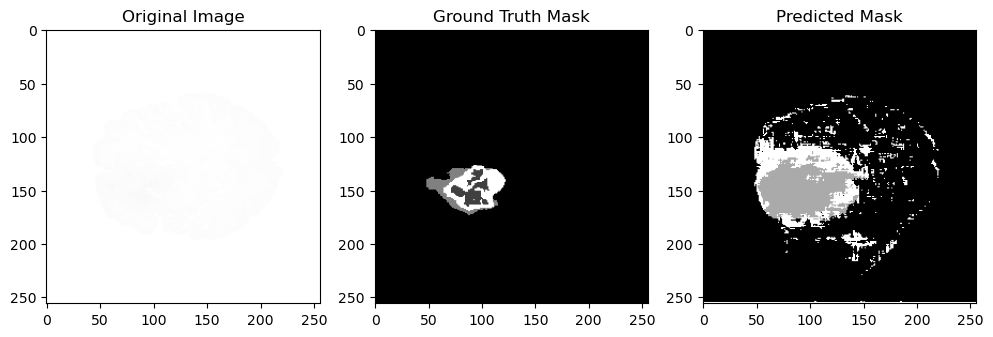

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction_values:  tensor([0., 1., 2., 3.])
Image dtype: float32
Mask dtype: int64
Prediction dtype: float32


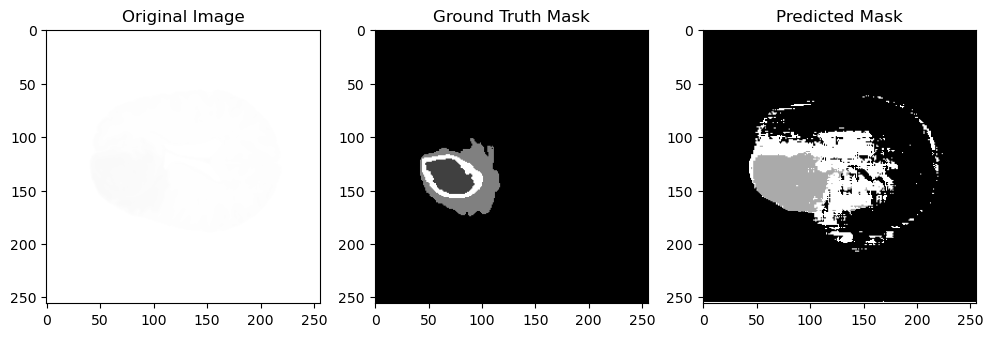

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction_values:  tensor([0., 1., 2., 3.])
Image dtype: float32
Mask dtype: int64
Prediction dtype: float32


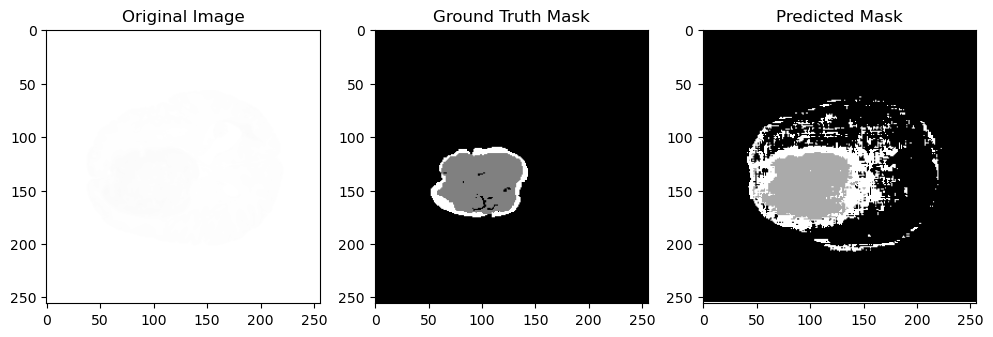

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction_values:  tensor([0., 1., 2., 3.])
Image dtype: float32
Mask dtype: int64
Prediction dtype: float32


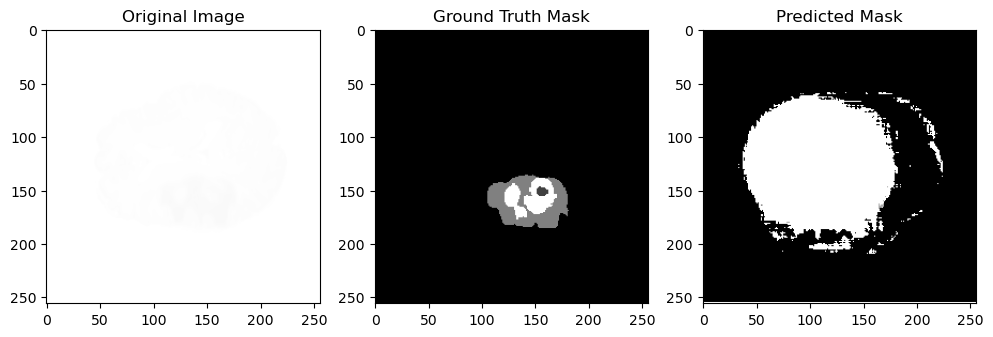

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction_values:  tensor([0., 1., 2., 3.])
Image dtype: float32
Mask dtype: int64
Prediction dtype: float32


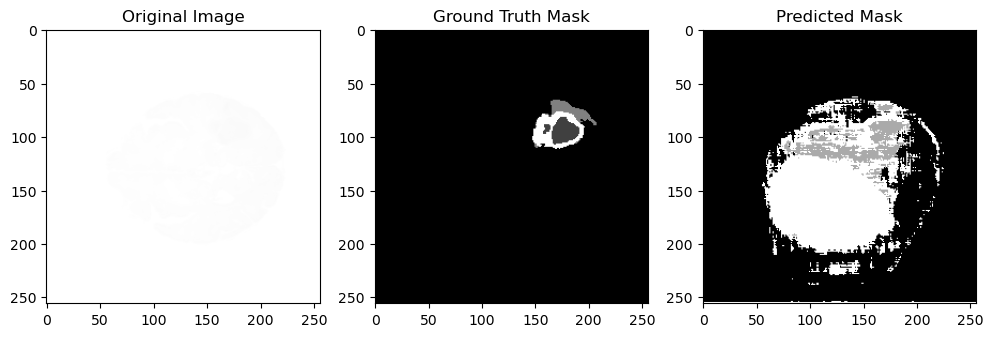

Loading G:/BraTS2021_preprocessed\batch_2_images.pt and G:/BraTS2021_preprocessed\batch_2_masks.pt...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction_values:  tensor([0., 1., 2., 3.])
Image dtype: float32
Mask dtype: int64
Prediction dtype: float32


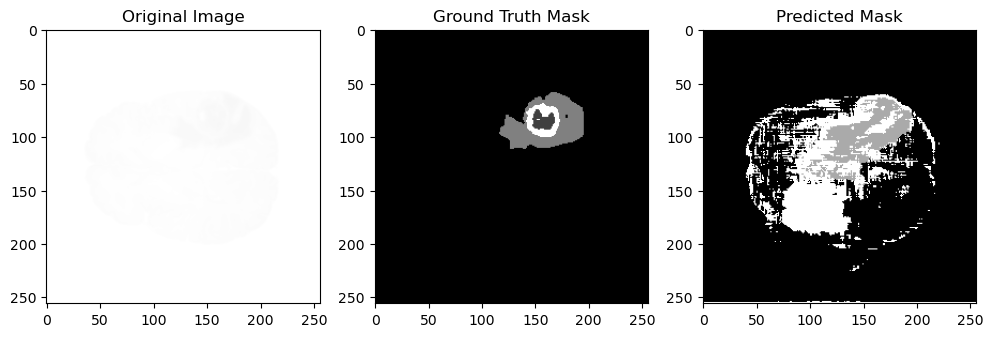

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction_values:  tensor([0., 1., 2., 3.])
Image dtype: float32
Mask dtype: int64
Prediction dtype: float32


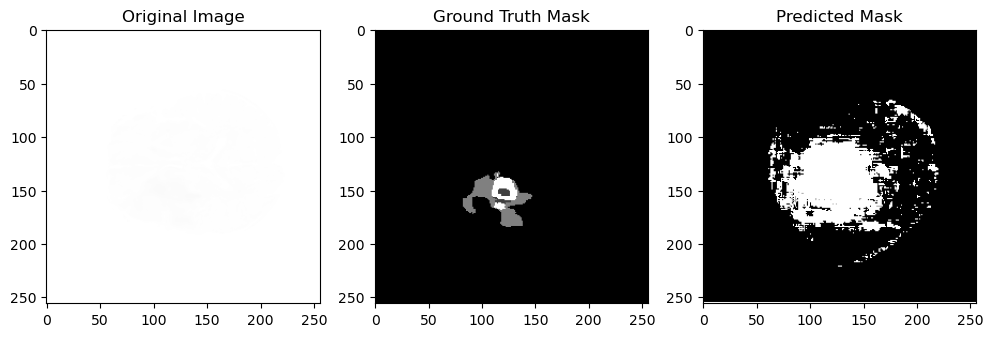

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction_values:  tensor([0., 1., 2., 3.])
Image dtype: float32
Mask dtype: int64
Prediction dtype: float32


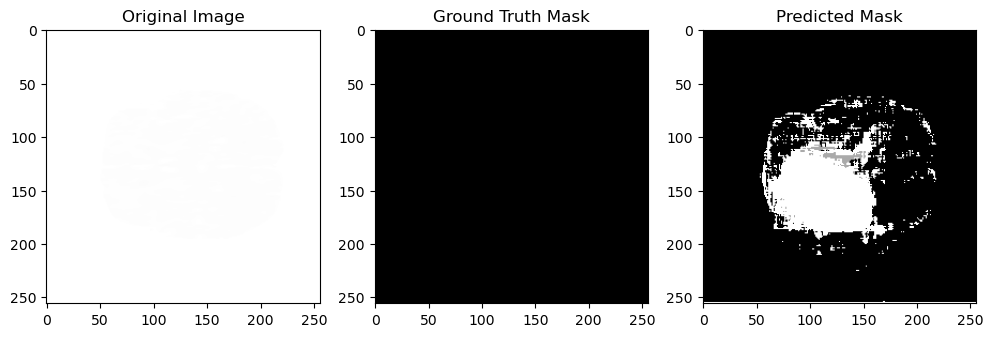

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction_values:  tensor([0., 2., 3.])
Image dtype: float32
Mask dtype: int64
Prediction dtype: float32


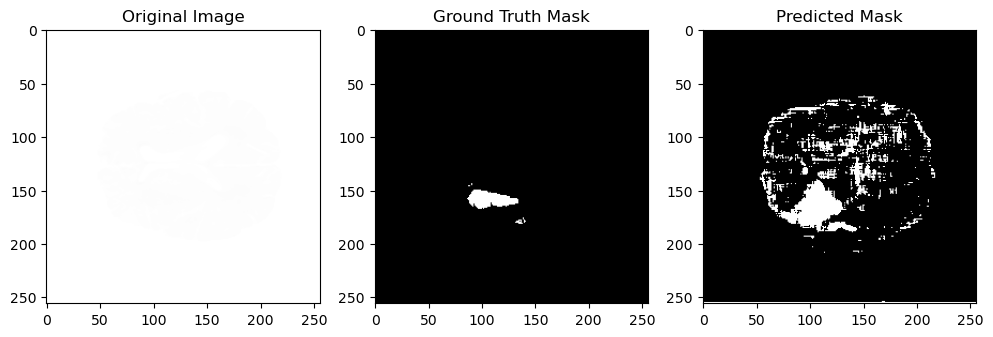

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction_values:  tensor([0., 1., 2., 3.])
Image dtype: float32
Mask dtype: int64
Prediction dtype: float32


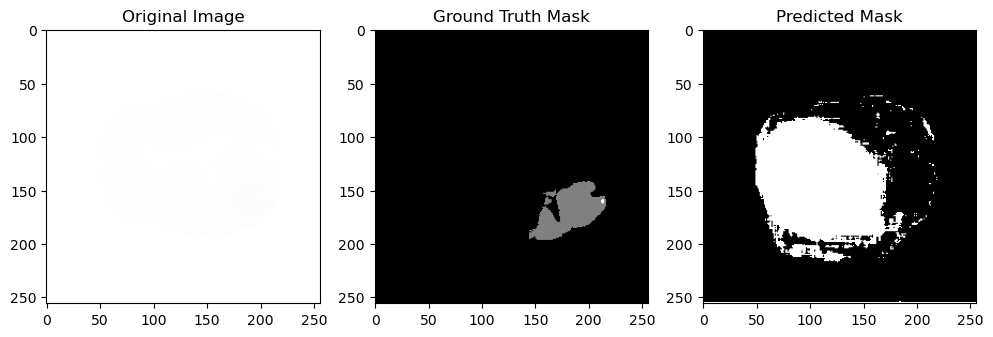

Testing complete!


In [11]:
import matplotlib.pyplot as plt

from torch.utils.data import random_split, DataLoader


test_batch_image_files = sorted(glob.glob("G:/BraTS2021_preprocessed/batch_*_images.pt"))
test_batch_mask_files = sorted(glob.glob("G:/BraTS2021_preprocessed/batch_*_masks.pt"))

i = 0

for img_file, mask_file in zip(test_batch_image_files, batch_mask_files):
    if i > 1:
        break
        
    print(f"Loading {img_file} and {mask_file}...")

    images = torch.load(img_file)
    masks = torch.load(mask_file)

    dataset = BraTSDataset(images, masks)
    test_loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0)  # No shuffle for test
    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    visualize_predictions(model, test_loader)

    i += 1  

    del images, masks, dataset, test_loader
    torch.cuda.empty_cache()

print("Testing complete!")

In [36]:
import torch
import gc


gc.collect()


for obj in list(gc.get_objects()):
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            del obj
    except:
        pass

gc.collect() 


30

In [16]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

loss_fxn = SMP.losses.DiceLoss(mode='multiclass')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    batch_image_files = sorted(glob.glob("G:/BraTS2021_preprocessed/batch_*_images.pt"))
    batch_mask_files = sorted(glob.glob("G:/BraTS2021_preprocessed/batch_*_masks.pt"))

    for img_file, mask_file in zip(batch_image_files, batch_mask_files):
        print(f"Loading {img_file} and {mask_file}...")

        images = torch.load(img_file)
        masks = torch.load(mask_file)

        dataset = BraTSDataset(images, masks)
        train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

        loop = tqdm(train_loader, desc=f"epoch {epoch+1}/{num_epochs}")

        for images, masks in loop:
            
            
        
            images = images.to(dtype=torch.float32)  
            masks = masks.to(dtype=torch.long)
            num_classes = 4
            masks = torch.clamp(masks, min=0, max=num_classes-1)  
            model = model.to(dtype=torch.float32)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = loss_fxn(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

torch.save(model.state_dict(), 'transfer_learning_model.pth')


Loading G:/BraTS2021_preprocessed\batch_1_images.pt and G:/BraTS2021_preprocessed\batch_1_masks.pt...


epoch 1/10:   0%|                                                                                            | 0/16 [00:00<?, ?it/s]C:\Users\HP-PC\AppData\Local\Temp\ipykernel_2356\4186411273.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)  # Change to float32
C:\Users\HP-PC\AppData\Local\Temp\ipykernel_2356\4186411273.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)
epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.47s/it, loss=0.742]


Epoch 1, Loss: 0.7636570557951927
Loading G:/BraTS2021_preprocessed\batch_2_images.pt and G:/BraTS2021_preprocessed\batch_2_masks.pt...


epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.33s/it, loss=0.752]


Epoch 1, Loss: 1.5137813985347748
Loading G:/BraTS2021_preprocessed\batch_3_images.pt and G:/BraTS2021_preprocessed\batch_3_masks.pt...


epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it, loss=0.706]


Epoch 1, Loss: 2.262158740311861
Loading G:/BraTS2021_preprocessed\batch_4_images.pt and G:/BraTS2021_preprocessed\batch_4_masks.pt...


epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it, loss=0.703]


Epoch 1, Loss: 2.9650071635842323
Loading G:/BraTS2021_preprocessed\batch_5_images.pt and G:/BraTS2021_preprocessed\batch_5_masks.pt...


epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.32s/it, loss=0.737]


Epoch 1, Loss: 3.672161716967821
Loading G:/BraTS2021_preprocessed\batch_6_images.pt and G:/BraTS2021_preprocessed\batch_6_masks.pt...


epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.70s/it, loss=0.692]


Epoch 1, Loss: 4.365903489291668
Loading G:/BraTS2021_preprocessed\batch_7_images.pt and G:/BraTS2021_preprocessed\batch_7_masks.pt...


epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it, loss=0.657]


Epoch 1, Loss: 70.5112853050232
Loading G:/BraTS2021_preprocessed\batch_1_images.pt and G:/BraTS2021_preprocessed\batch_1_masks.pt...


epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it, loss=0.218]


Epoch 2, Loss: 0.6466596443206072
Loading G:/BraTS2021_preprocessed\batch_2_images.pt and G:/BraTS2021_preprocessed\batch_2_masks.pt...


epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.43s/it, loss=0.674]


Epoch 2, Loss: 1.282820463180542
Loading G:/BraTS2021_preprocessed\batch_3_images.pt and G:/BraTS2021_preprocessed\batch_3_masks.pt...


epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.33s/it, loss=0.272]


Epoch 2, Loss: 1.9296827390789986
Loading G:/BraTS2021_preprocessed\batch_4_images.pt and G:/BraTS2021_preprocessed\batch_4_masks.pt...


epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.66s/it, loss=0.682]


Epoch 2, Loss: 2.5919593423604965
Loading G:/BraTS2021_preprocessed\batch_5_images.pt and G:/BraTS2021_preprocessed\batch_5_masks.pt...


epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.62s/it, loss=0.539]


Epoch 2, Loss: 3.182459097355604
Loading G:/BraTS2021_preprocessed\batch_6_images.pt and G:/BraTS2021_preprocessed\batch_6_masks.pt...


epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.33s/it, loss=0.591]


Epoch 2, Loss: 3.8067332208156586
Loading G:/BraTS2021_preprocessed\batch_7_images.pt and G:/BraTS2021_preprocessed\batch_7_masks.pt...


epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it, loss=0.593]


Epoch 2, Loss: 61.50029641389847
Loading G:/BraTS2021_preprocessed\batch_1_images.pt and G:/BraTS2021_preprocessed\batch_1_masks.pt...


epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.58s/it, loss=0.093]


Epoch 3, Loss: 0.5739405360072851
Loading G:/BraTS2021_preprocessed\batch_2_images.pt and G:/BraTS2021_preprocessed\batch_2_masks.pt...


epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.45s/it, loss=0.538]


Epoch 3, Loss: 1.1705752555280924
Loading G:/BraTS2021_preprocessed\batch_3_images.pt and G:/BraTS2021_preprocessed\batch_3_masks.pt...


epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.57s/it, loss=0.552]


Epoch 3, Loss: 1.7658900376409292
Loading G:/BraTS2021_preprocessed\batch_4_images.pt and G:/BraTS2021_preprocessed\batch_4_masks.pt...


epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.47s/it, loss=0.395]


Epoch 3, Loss: 2.3235357590019703
Loading G:/BraTS2021_preprocessed\batch_5_images.pt and G:/BraTS2021_preprocessed\batch_5_masks.pt...


epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.32s/it, loss=0.403]


Epoch 3, Loss: 2.858177989721298
Loading G:/BraTS2021_preprocessed\batch_6_images.pt and G:/BraTS2021_preprocessed\batch_6_masks.pt...


epoch 3/10: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.43s/it, loss=0.0602]


Epoch 3, Loss: 3.36235186830163
Loading G:/BraTS2021_preprocessed\batch_7_images.pt and G:/BraTS2021_preprocessed\batch_7_masks.pt...


epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it, loss=0.495]


Epoch 3, Loss: 54.29261916875839
Loading G:/BraTS2021_preprocessed\batch_1_images.pt and G:/BraTS2021_preprocessed\batch_1_masks.pt...


epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.47s/it, loss=0.691]


Epoch 4, Loss: 0.49916058126837015
Loading G:/BraTS2021_preprocessed\batch_2_images.pt and G:/BraTS2021_preprocessed\batch_2_masks.pt...


epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.44s/it, loss=0.456]


Epoch 4, Loss: 1.011962347663939
Loading G:/BraTS2021_preprocessed\batch_3_images.pt and G:/BraTS2021_preprocessed\batch_3_masks.pt...


epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.38s/it, loss=0.00966]


Epoch 4, Loss: 1.4692872166633606
Loading G:/BraTS2021_preprocessed\batch_4_images.pt and G:/BraTS2021_preprocessed\batch_4_masks.pt...


epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.35s/it, loss=0.335]


Epoch 4, Loss: 1.9643008653074503
Loading G:/BraTS2021_preprocessed\batch_5_images.pt and G:/BraTS2021_preprocessed\batch_5_masks.pt...


epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:24<00:00,  1.53s/it, loss=0.361]


Epoch 4, Loss: 2.3992634024471045
Loading G:/BraTS2021_preprocessed\batch_6_images.pt and G:/BraTS2021_preprocessed\batch_6_masks.pt...


epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.34s/it, loss=0.126]


Epoch 4, Loss: 2.796169640496373
Loading G:/BraTS2021_preprocessed\batch_7_images.pt and G:/BraTS2021_preprocessed\batch_7_masks.pt...


epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it, loss=0.381]


Epoch 4, Loss: 45.11948695778847
Loading G:/BraTS2021_preprocessed\batch_1_images.pt and G:/BraTS2021_preprocessed\batch_1_masks.pt...


epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.68s/it, loss=0.286]


Epoch 5, Loss: 0.39327218011021614
Loading G:/BraTS2021_preprocessed\batch_2_images.pt and G:/BraTS2021_preprocessed\batch_2_masks.pt...


epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it, loss=0.458]


Epoch 5, Loss: 0.8425615066662431
Loading G:/BraTS2021_preprocessed\batch_3_images.pt and G:/BraTS2021_preprocessed\batch_3_masks.pt...


epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it, loss=0.298]


Epoch 5, Loss: 1.2426004046574235
Loading G:/BraTS2021_preprocessed\batch_4_images.pt and G:/BraTS2021_preprocessed\batch_4_masks.pt...


epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.33s/it, loss=0.267]


Epoch 5, Loss: 1.5914843017235398
Loading G:/BraTS2021_preprocessed\batch_5_images.pt and G:/BraTS2021_preprocessed\batch_5_masks.pt...


epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.32s/it, loss=0.318]


Epoch 5, Loss: 1.8797164792194963
Loading G:/BraTS2021_preprocessed\batch_6_images.pt and G:/BraTS2021_preprocessed\batch_6_masks.pt...


epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.31s/it, loss=0.259]


Epoch 5, Loss: 2.2316160881891847
Loading G:/BraTS2021_preprocessed\batch_7_images.pt and G:/BraTS2021_preprocessed\batch_7_masks.pt...


epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it, loss=0.337]


Epoch 5, Loss: 36.04237271845341
Loading G:/BraTS2021_preprocessed\batch_1_images.pt and G:/BraTS2021_preprocessed\batch_1_masks.pt...


epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it, loss=0.261]


Epoch 6, Loss: 0.2970519168302417
Loading G:/BraTS2021_preprocessed\batch_2_images.pt and G:/BraTS2021_preprocessed\batch_2_masks.pt...


epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it, loss=0.281]


Epoch 6, Loss: 0.6063797902315855
Loading G:/BraTS2021_preprocessed\batch_3_images.pt and G:/BraTS2021_preprocessed\batch_3_masks.pt...


epoch 6/10: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it, loss=0.0027]


Epoch 6, Loss: 0.8138108961284161
Loading G:/BraTS2021_preprocessed\batch_4_images.pt and G:/BraTS2021_preprocessed\batch_4_masks.pt...


epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.30s/it, loss=0.337]


Epoch 6, Loss: 1.1095407530665398
Loading G:/BraTS2021_preprocessed\batch_5_images.pt and G:/BraTS2021_preprocessed\batch_5_masks.pt...


epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it, loss=0.281]


Epoch 6, Loss: 1.333496873266995
Loading G:/BraTS2021_preprocessed\batch_6_images.pt and G:/BraTS2021_preprocessed\batch_6_masks.pt...


epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it, loss=0.19]


Epoch 6, Loss: 1.58937874622643
Loading G:/BraTS2021_preprocessed\batch_7_images.pt and G:/BraTS2021_preprocessed\batch_7_masks.pt...


epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it, loss=0.244]


Epoch 6, Loss: 25.674318447709084
Loading G:/BraTS2021_preprocessed\batch_1_images.pt and G:/BraTS2021_preprocessed\batch_1_masks.pt...


epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it, loss=0.43]


Epoch 7, Loss: 0.2525280164554715
Loading G:/BraTS2021_preprocessed\batch_2_images.pt and G:/BraTS2021_preprocessed\batch_2_masks.pt...


epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it, loss=0.14]


Epoch 7, Loss: 0.5351262670010328
Loading G:/BraTS2021_preprocessed\batch_3_images.pt and G:/BraTS2021_preprocessed\batch_3_masks.pt...


epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.31s/it, loss=0.563]


Epoch 7, Loss: 0.774978962726891
Loading G:/BraTS2021_preprocessed\batch_4_images.pt and G:/BraTS2021_preprocessed\batch_4_masks.pt...


epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.28s/it, loss=0.149]


Epoch 7, Loss: 1.0240604178979993
Loading G:/BraTS2021_preprocessed\batch_5_images.pt and G:/BraTS2021_preprocessed\batch_5_masks.pt...


epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it, loss=0.213]


Epoch 7, Loss: 1.2571900822222233
Loading G:/BraTS2021_preprocessed\batch_6_images.pt and G:/BraTS2021_preprocessed\batch_6_masks.pt...


epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.32s/it, loss=0.292]


Epoch 7, Loss: 1.4909986276179552
Loading G:/BraTS2021_preprocessed\batch_7_images.pt and G:/BraTS2021_preprocessed\batch_7_masks.pt...


epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it, loss=0.231]


Epoch 7, Loss: 24.0873534232378
Loading G:/BraTS2021_preprocessed\batch_1_images.pt and G:/BraTS2021_preprocessed\batch_1_masks.pt...


epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it, loss=0.127]


Epoch 8, Loss: 0.20900061633437872
Loading G:/BraTS2021_preprocessed\batch_2_images.pt and G:/BraTS2021_preprocessed\batch_2_masks.pt...


epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it, loss=0.165]


Epoch 8, Loss: 0.4489098945632577
Loading G:/BraTS2021_preprocessed\batch_3_images.pt and G:/BraTS2021_preprocessed\batch_3_masks.pt...


epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.28s/it, loss=0.244]


Epoch 8, Loss: 0.6520752888172865
Loading G:/BraTS2021_preprocessed\batch_4_images.pt and G:/BraTS2021_preprocessed\batch_4_masks.pt...


epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it, loss=0.123]


Epoch 8, Loss: 0.8921879846602678
Loading G:/BraTS2021_preprocessed\batch_5_images.pt and G:/BraTS2021_preprocessed\batch_5_masks.pt...


epoch 8/10: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.29s/it, loss=0.0741]


Epoch 8, Loss: 1.085611393675208
Loading G:/BraTS2021_preprocessed\batch_6_images.pt and G:/BraTS2021_preprocessed\batch_6_masks.pt...


epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.28s/it, loss=0.216]


Epoch 8, Loss: 1.3201613239943981
Loading G:/BraTS2021_preprocessed\batch_7_images.pt and G:/BraTS2021_preprocessed\batch_7_masks.pt...


epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it, loss=0.212]


Epoch 8, Loss: 21.334523916244507
Loading G:/BraTS2021_preprocessed\batch_1_images.pt and G:/BraTS2021_preprocessed\batch_1_masks.pt...


epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.28s/it, loss=0.021]


Epoch 9, Loss: 0.21807052101939917
Loading G:/BraTS2021_preprocessed\batch_2_images.pt and G:/BraTS2021_preprocessed\batch_2_masks.pt...


epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.33s/it, loss=0.34]


Epoch 9, Loss: 0.4793092170730233
Loading G:/BraTS2021_preprocessed\batch_3_images.pt and G:/BraTS2021_preprocessed\batch_3_masks.pt...


epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.30s/it, loss=0.179]


Epoch 9, Loss: 0.6653665155172348
Loading G:/BraTS2021_preprocessed\batch_4_images.pt and G:/BraTS2021_preprocessed\batch_4_masks.pt...


epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.26s/it, loss=0.124]


Epoch 9, Loss: 0.8617151668295264
Loading G:/BraTS2021_preprocessed\batch_5_images.pt and G:/BraTS2021_preprocessed\batch_5_masks.pt...


epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.30s/it, loss=0.314]


Epoch 9, Loss: 1.038043492473662
Loading G:/BraTS2021_preprocessed\batch_6_images.pt and G:/BraTS2021_preprocessed\batch_6_masks.pt...


epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.39s/it, loss=0.209]


Epoch 9, Loss: 1.2297624526545405
Loading G:/BraTS2021_preprocessed\batch_7_images.pt and G:/BraTS2021_preprocessed\batch_7_masks.pt...


epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it, loss=0.206]


Epoch 9, Loss: 19.881807446479797
Loading G:/BraTS2021_preprocessed\batch_1_images.pt and G:/BraTS2021_preprocessed\batch_1_masks.pt...


epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.24s/it, loss=0.21]


Epoch 10, Loss: 0.17188096791505814
Loading G:/BraTS2021_preprocessed\batch_2_images.pt and G:/BraTS2021_preprocessed\batch_2_masks.pt...


epoch 10/10: 100%|████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it, loss=0.00106]


Epoch 10, Loss: 0.3735471721738577
Loading G:/BraTS2021_preprocessed\batch_3_images.pt and G:/BraTS2021_preprocessed\batch_3_masks.pt...


epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.34s/it, loss=0.575]


Epoch 10, Loss: 0.5814078263938427
Loading G:/BraTS2021_preprocessed\batch_4_images.pt and G:/BraTS2021_preprocessed\batch_4_masks.pt...


epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.26s/it, loss=0.419]


Epoch 10, Loss: 0.8333158120512962
Loading G:/BraTS2021_preprocessed\batch_5_images.pt and G:/BraTS2021_preprocessed\batch_5_masks.pt...


epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it, loss=0.148]


Epoch 10, Loss: 0.9990698900073767
Loading G:/BraTS2021_preprocessed\batch_6_images.pt and G:/BraTS2021_preprocessed\batch_6_masks.pt...


epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.29s/it, loss=0.139]


Epoch 10, Loss: 1.1873085061088204
Loading G:/BraTS2021_preprocessed\batch_7_images.pt and G:/BraTS2021_preprocessed\batch_7_masks.pt...


epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it, loss=0.185]


Epoch 10, Loss: 19.181865334510803
